Results of running GPT-2 on IMDb movie reviews without any fine-tuning

Train and test data exploration:
1. No of samples
2. No of positive / negative samples.
3. Length of the movie reviews

Predict the next word given the following prompt
 
'''
Review: The movie was awesome. Sentiment: Positive. 
Review: The performances were disappointing. Sentiment: Negative. 
Review: {review} Sentiment:
'''
I calculate the probabilities of the word " Positive" and " Negative" and classify the review based on which probability is greater.

In [4]:
import pandas
from torch.utils.data import Dataset
from sentiment_classification.reviewsDataset import reviewsDataset


In [2]:
# Dataset exploration

imdb_train = reviewsDataset("train",max_length=10000)
imdb_test = reviewsDataset("test",max_length=10000)


def format_data(dataset: Dataset) -> pandas.DataFrame:

    data = []
    for batch in dataset:
        data.append({"input_ids":len(batch["input_ids"]),
                    "label": batch["label"],
                    "filename": batch["fpath"]})
    
    return pandas.DataFrame(data)

train_data = format_data(imdb_train)
test_data = format_data(imdb_test)


Summary statistics of the dataset

In [3]:
def summary(data: pandas.DataFrame) -> None:
    print(f"Number of reviews: {len(data)}")
    print(f"Positive Reviews: {data[data['label'] == 1]['label'].count()}")
    print(f"Negative Reviews: {data[data['label'] == 0]['label'].count()}")
    print(f"Max Review Length: {data['input_ids'].max()}\nMin Review Length: {data['input_ids'].min()}")
    print(f"Median Review Length: {data['input_ids'].median()}\nMean Review Length: {data['input_ids'].mean()}")

print("Train\n--------------")
summary(train_data)
print("Test\n---------------")
summary(test_data)

Train
--------------
Number of reviews: 25000
Positive Reviews: 12500
Negative Reviews: 12500
Max Review Length: 3066
Min Review Length: 40
Median Review Length: 243.0
Mean Review Length: 317.86728
Test
---------------
Number of reviews: 25000
Positive Reviews: 12500
Negative Reviews: 12500
Max Review Length: 2795
Min Review Length: 37
Median Review Length: 241.0
Mean Review Length: 311.17776


Length of reviews (measured by the number of tokens)

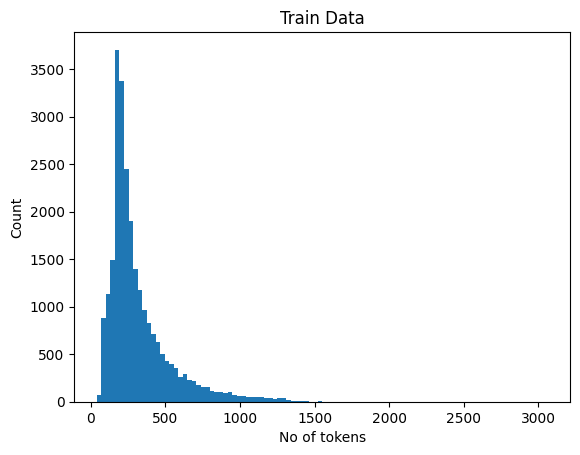

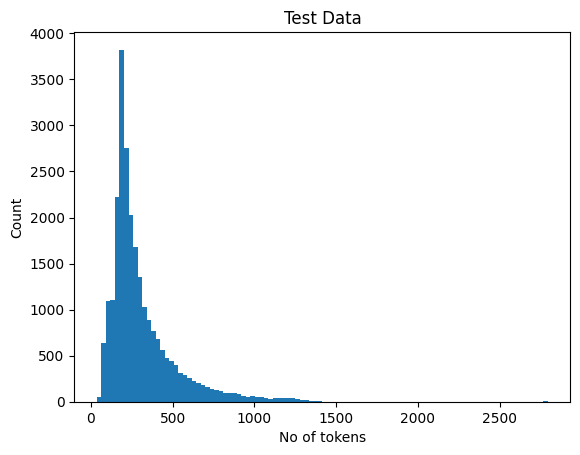

In [4]:
from matplotlib import pyplot as plt
def plot_hist(title: str,df: pandas.DataFrame) -> None:
    plt.figure()
    plt.hist(df["input_ids"],bins=100)
    plt.xlabel(f"No of tokens")
    plt.ylabel("Count")
    plt.title(f"{title}")

plot_hist(title='Train Data', df=train_data) 
plot_hist(title="Test Data", df=test_data)   

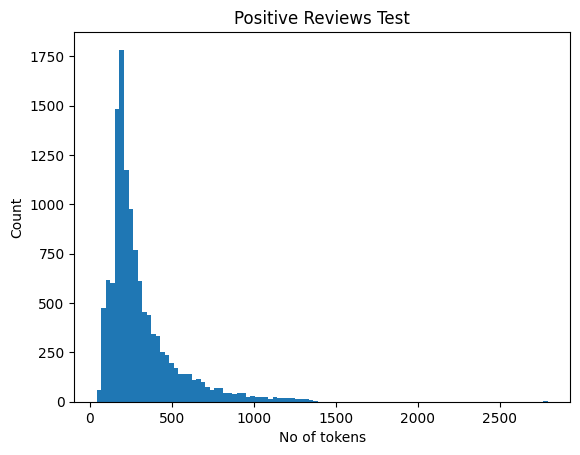

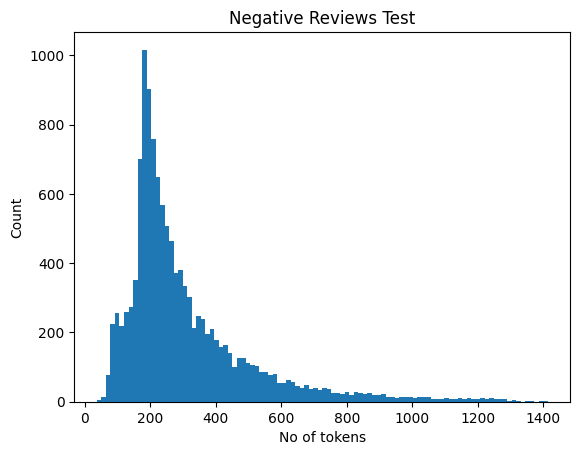

In [5]:
plot_hist(title="Positive Reviews Test",df=test_data[test_data['label']==1])
plot_hist(title="Negative Reviews Test",df=test_data[test_data['label']==0])

Run the test.py in `sentiment_classification` and write the results to a file

In [5]:
def get_metrics_by_bin(results, bins,threshold=0.5):
    TP = len(results[(results["label"] >= threshold) & (results["prediction"] >= threshold)])
    FP = len(results[(results["label"] < threshold) & (results["prediction"] >= threshold)])
    TN = len(results[(results["label"] < threshold) & (results["prediction"] < threshold)])
    FN = len(results[(results["label"] > threshold) & (results["prediction"] < threshold)])
    
    print("Metrics")
    print(f"Precision: {TP/(TP+FP)}\nRecall: {TP/(TP+FN)}\nAccuracy: {(TP+TN)/len(results)}")
    bins = range(0,1500,128)
    results["bin"] = pandas.cut(results['length'],bins)
    metrics_by_bin = results.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"] >= threshold) & (x["prediction"] >= threshold)).sum(),
                                                                            "FP":((x["label"] < threshold) & (x["prediction"] >= threshold)).sum(),
                                                                            "FN": ((x["label"] >= threshold) & (x["prediction"] < threshold)).sum(),
                                                                            "TN": ((x["label"] < threshold) & (x["prediction"] < threshold)).sum()}))

    metrics_by_bin["accuracy"] = (metrics_by_bin["TP"] + metrics_by_bin["TN"])/(metrics_by_bin["TP"] + metrics_by_bin["TN"]+ metrics_by_bin["FP"]+ metrics_by_bin["FN"])
    metrics_by_bin["precision"] = metrics_by_bin["TP"]/(metrics_by_bin["TP"] + metrics_by_bin["FP"])
    metrics_by_bin["recall"] = metrics_by_bin["TP"]/(metrics_by_bin["TP"] + metrics_by_bin["FN"])
    print("Metrics by bin")
    print(metrics_by_bin.to_markdown())

**Run evaluation for the zero shot approach**

In [1]:
from sentiment_classification.reviewsDataset import reviewsDataset
from sentiment_classification.eval import Eval
from sentiment_classification.eval_config import EvalConfig
from gpt_config import GPTConfig

In [8]:
model_config = GPTConfig(block_size=128,use_lora=False)
eval_config = EvalConfig(results_path="zero_shot_128.txt",subset=False)
test_set = reviewsDataset(split="test")
evaluator = Eval(test_set=test_set,eval_config=eval_config,model_config=model_config)
evaluator.evaluate()

Loading pre-trained weights for gpt2
Number of parameters: 123.65M


100%|██████████| 12500/12500 [08:14<00:00, 25.27it/s]


In [9]:
res_file = pandas.read_csv("zero_shot_128.txt")
bins = range(0,1500,128)
get_metrics_by_bin(res_file,bins,threshold=0.5)

Metrics
Precision: 0.6137839536345228
Recall: 0.7032
Accuracy: 0.63036
Metrics by bin
| bin          |   TP |   FP |   FN |   TN |   accuracy |   precision |   recall |
|:-------------|-----:|-----:|-----:|-----:|-----------:|------------:|---------:|
| (0, 128]     | 1214 |  580 |  636 | 1009 |   0.646409 |    0.6767   | 0.656216 |
| (128, 256]   | 4251 | 2664 | 1650 | 3390 |   0.639147 |    0.614751 | 0.720386 |
| (256, 384]   | 1516 | 1050 |  652 | 1269 |   0.620682 |    0.590803 | 0.699262 |
| (384, 512]   |  741 |  567 |  316 |  579 |   0.599183 |    0.566514 | 0.701041 |
| (512, 640]   |  429 |  279 |  173 |  297 |   0.616299 |    0.605932 | 0.712625 |
| (640, 768]   |  249 |  159 |  114 |  163 |   0.60146  |    0.610294 | 0.68595  |
| (768, 896]   |  151 |   98 |   62 |  109 |   0.619048 |    0.606426 | 0.70892  |
| (896, 1024]  |   93 |   55 |   46 |   63 |   0.607004 |    0.628378 | 0.669065 |
| (1024, 1152] |   67 |   33 |   27 |   53 |   0.666667 |    0.67     | 0.712766 |
|

/var/folders/p1/qmcgqwhj1mx925j0j_r36xp40000gn/T/ipykernel_47759/3153587618.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metrics_by_bin = results.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"] >= threshold) & (x["prediction"] >= threshold)).sum(),
/var/folders/p1/qmcgqwhj1mx925j0j_r36xp40000gn/T/ipykernel_47759/3153587618.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_bin = results.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"] >= threshold) & (x["

In [8]:
import torch
from sentiment_classification.train import Trainer
from sentiment_classification.train_config import TrainConfig
from gpt_config import GPTConfig
from sentiment_classification.reviewsDataset import reviewsDataset

train_config = TrainConfig(out_dir="run",init_from="resume",checkpoint_name="finetune_no_lora.ckpt")
model_config = GPTConfig(use_lora=False)
rd = reviewsDataset(split="train",max_length=model_config.block_size)
train_set, val_set = torch.utils.data.random_split(rd,[0.85,0.15])
trainer = Trainer(train_set,val_set,train_config,model_config)
trainer.train()

Loading pre-trained weights for gpt2
Number of parameters: 123.65M
Resuming training from run/finetune_no_lora.ckpt


/Users/varun/Documents/learning/Projects/ml-practice/transformers/sentiment_classification/train.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.ckpt = torch.load(

num decayed parameter tensors: 50, with 123,630,336 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters


  0%|          | 0/24500 [00:00<?, ?it/s]

Step: 5500
 Train Loss: 0.2445705235004425
Validation Loss: 0.4386473596096039
Saving checkpoint to run/finetune_no_lora.ckpt


  2%|▏         | 500/24500 [02:52<2:01:48,  3.28it/s]

Step: 6000
 Train Loss: 0.5800596475601196
Validation Loss: 1.0644642114639282
Saving checkpoint to run/finetune_no_lora.ckpt


  4%|▍         | 1000/24500 [05:43<1:57:59,  3.32it/s]

Step: 6500
 Train Loss: 0.28678107261657715
Validation Loss: 0.3674701154232025
Saving checkpoint to run/finetune_no_lora.ckpt


  6%|▌         | 1500/24500 [09:33<2:34:33,  2.48it/s] 

Step: 7000
 Train Loss: 0.3288807272911072
Validation Loss: 0.521355390548706
Saving checkpoint to run/finetune_no_lora.ckpt


  8%|▊         | 2000/24500 [12:46<2:03:56,  3.03it/s] 

Step: 7500
 Train Loss: 0.3946543335914612
Validation Loss: 0.21819980442523956
Saving checkpoint to run/finetune_no_lora.ckpt


 10%|█         | 2500/24500 [15:55<1:56:40,  3.14it/s] 

Step: 8000
 Train Loss: 0.2796522080898285
Validation Loss: 0.28128671646118164
Saving checkpoint to run/finetune_no_lora.ckpt


 11%|█         | 2603/24500 [16:56<3:59:26,  1.52it/s] 

**Run eval using the fine-tuned model**

In [2]:
model_config = GPTConfig(block_size=128,use_lora=False,load_from_checkpoint=True,checkpoint_path="run/finetune_no_lora.ckpt")
eval_config = EvalConfig(results_path="finetuned_no_lora.txt")
test_set = reviewsDataset(split="test")
evaluator = Eval(test_set=test_set,eval_config=eval_config,model_config=model_config)
evaluator.evaluate()

Loading pre-trained weights for gpt2
Number of parameters: 123.65M


/Users/varun/Documents/learning/Projects/ml-practice/transformers/sentiment_classification/eval.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.m

**Test the performance of the fine-tuned model**

In [7]:
res_file = pandas.read_csv("finetuned_no_lora.txt")
bins = range(0,1500,128)
get_metrics_by_bin(res_file,bins,threshold=0.5)

Metrics
Precision: 0.7086092715231788
Recall: 0.856
Accuracy: 0.752
Metrics by bin
| bin          |   TP |   FP |   FN |   TN |   accuracy |   precision |     recall |
|:-------------|-----:|-----:|-----:|-----:|-----------:|------------:|-----------:|
| (0, 128]     |   21 |    6 |    2 |    9 |   0.789474 |    0.777778 |   0.913043 |
| (128, 256]   |   48 |   19 |   10 |   48 |   0.768    |    0.716418 |   0.827586 |
| (256, 384]   |   17 |    8 |    4 |   11 |   0.7      |    0.68     |   0.809524 |
| (384, 512]   |    8 |    7 |    1 |   10 |   0.692308 |    0.533333 |   0.888889 |
| (512, 640]   |    9 |    1 |    1 |    1 |   0.833333 |    0.9      |   0.9      |
| (640, 768]   |    2 |    1 |    0 |    2 |   0.8      |    0.666667 |   1        |
| (768, 896]   |    1 |    2 |    0 |    0 |   0.333333 |    0.333333 |   1        |
| (896, 1024]  |    1 |    0 |    0 |    0 |   1        |    1        |   1        |
| (1024, 1152] |    0 |    0 |    0 |    0 | nan        |  nan     

/var/folders/p1/qmcgqwhj1mx925j0j_r36xp40000gn/T/ipykernel_49051/3153587618.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metrics_by_bin = results.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"] >= threshold) & (x["prediction"] >= threshold)).sum(),
/var/folders/p1/qmcgqwhj1mx925j0j_r36xp40000gn/T/ipykernel_49051/3153587618.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_bin = results.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"] >= threshold) & (x["

**Run training using LoRA**

In [ ]:
train_config = TrainConfig(out_dir="run",checkpoint_name="finetune_lora.ckpt")
model_config = GPTConfig(use_lora=True,r=8)
rd = reviewsDataset(split="train",max_length=model_config.block_size)
train_set, val_set = torch.utils.data.random_split(rd,[0.85,0.15])
trainer = Trainer(train_set,val_set,train_config,model_config)
trainer.train()

**Evaluate using the LoRA finetuned model**

In [ ]:
model_config = GPTConfig(block_size=128,use_lora=True,load_from_checkpoint=True,checkpoint_path="run/finetune_lora.ckpt")
eval_config = EvalConfig(results_path="finetuned_lora.txt")
test_set = reviewsDataset(split="test")
evaluator = Eval(test_set=test_set,eval_config=eval_config,model_config=model_config)
evaluator.evaluate()

**Test the performance of the LoRA finetuned model**

In [ ]:
res_file = pandas.read_csv("finetuned_lora.txt")
bins = range(0,1500,128)
get_metrics_by_bin(res_file,bins,threshold=0.5)